## DS 6003 - Spark Assignment
### Name: Mengyao Zhang (mz6jv)

In [1]:
#libraries
import os
from os import listdir
from os.path import isfile, join
import boto3

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
from pyspark.sql import functions as fc

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Context creation

In [2]:
role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# Configure and create spark context
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()


In [3]:
spark # check 

In [4]:
# create pyspark SQL context
sqlc = pyspark.sql.SQLContext(spark)

In [5]:
sqlc

### 2. Prepare data

#### Read in data

In [6]:
# set s3 path
bucket='odl-spark19spds6003-001'
data_key = 'mz6jv/HousePrices.csv'

data_location = 's3a://{}/{}'.format(bucket, data_key)

# read csv file from s3
df = sqlc.read.format('csv')\
    .option("header","true")\
    .option("inferSchema", "true")\
    .load(data_location)

In [7]:
df

DataFrame[Area: int, Garage: int, FirePlace: int, Baths: int, White Marble: int, Black Marble: int, Indian Marble: int, Floors: int, City: int, Solar: int, Electric: int, Fiber: int, Glass Doors: int, Swiming Pool: int, Garden: int, Prices: int]

In [8]:
df.printSchema() # check schema

root
 |-- Area: integer (nullable = true)
 |-- Garage: integer (nullable = true)
 |-- FirePlace: integer (nullable = true)
 |-- Baths: integer (nullable = true)
 |-- White Marble: integer (nullable = true)
 |-- Black Marble: integer (nullable = true)
 |-- Indian Marble: integer (nullable = true)
 |-- Floors: integer (nullable = true)
 |-- City: integer (nullable = true)
 |-- Solar: integer (nullable = true)
 |-- Electric: integer (nullable = true)
 |-- Fiber: integer (nullable = true)
 |-- Glass Doors: integer (nullable = true)
 |-- Swiming Pool: integer (nullable = true)
 |-- Garden: integer (nullable = true)
 |-- Prices: integer (nullable = true)



In [9]:
# rename column names with white space
df = df.withColumnRenamed("White Marble", "WhiteMarble")\
       .withColumnRenamed("Black Marble", "BlackMarble")\
       .withColumnRenamed("Indian Marble", "IndianMarble")\
       .withColumnRenamed("Glass Doors", "GlassDoors")\
       .withColumnRenamed("Swiming Pool", "SwimmingPool")
        

In [10]:
df.printSchema() # check names

root
 |-- Area: integer (nullable = true)
 |-- Garage: integer (nullable = true)
 |-- FirePlace: integer (nullable = true)
 |-- Baths: integer (nullable = true)
 |-- WhiteMarble: integer (nullable = true)
 |-- BlackMarble: integer (nullable = true)
 |-- IndianMarble: integer (nullable = true)
 |-- Floors: integer (nullable = true)
 |-- City: integer (nullable = true)
 |-- Solar: integer (nullable = true)
 |-- Electric: integer (nullable = true)
 |-- Fiber: integer (nullable = true)
 |-- GlassDoors: integer (nullable = true)
 |-- SwimmingPool: integer (nullable = true)
 |-- Garden: integer (nullable = true)
 |-- Prices: integer (nullable = true)



In [11]:
df.take(5) # see 5 obs

[Row(Area=164, Garage=2, FirePlace=0, Baths=2, WhiteMarble=0, BlackMarble=1, IndianMarble=0, Floors=0, City=3, Solar=1, Electric=1, Fiber=1, GlassDoors=1, SwimmingPool=0, Garden=0, Prices=43800),
 Row(Area=84, Garage=2, FirePlace=0, Baths=4, WhiteMarble=0, BlackMarble=0, IndianMarble=1, Floors=1, City=2, Solar=0, Electric=0, Fiber=0, GlassDoors=1, SwimmingPool=1, Garden=1, Prices=37550),
 Row(Area=190, Garage=2, FirePlace=4, Baths=4, WhiteMarble=1, BlackMarble=0, IndianMarble=0, Floors=0, City=2, Solar=0, Electric=0, Fiber=1, GlassDoors=0, SwimmingPool=0, Garden=0, Prices=49500),
 Row(Area=75, Garage=2, FirePlace=4, Baths=4, WhiteMarble=0, BlackMarble=0, IndianMarble=1, Floors=1, City=1, Solar=1, Electric=1, Fiber=1, GlassDoors=1, SwimmingPool=1, Garden=1, Prices=50075),
 Row(Area=148, Garage=1, FirePlace=4, Baths=2, WhiteMarble=1, BlackMarble=0, IndianMarble=0, Floors=1, City=2, Solar=1, Electric=0, Fiber=0, GlassDoors=1, SwimmingPool=1, Garden=1, Prices=52400)]

#### Write parquet to S3

In [16]:
# write parquet to local 
parquetPath = './tmpPqt'
df.write.parquet(parquetPath)

In [21]:
# write parquet to s3
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')

for f in files:
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "mz6jv/pqt/"+f)

In [22]:
files

['part-00003-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet',
 '.part-00004-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet.crc',
 '.part-00000-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet.crc',
 '.part-00002-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet.crc',
 'part-00002-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet',
 'part-00004-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet',
 '.part-00001-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet.crc',
 '._SUCCESS.crc',
 'part-00000-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet',
 'part-00001-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet',
 '_SUCCESS',
 '.part-00003-51b803ca-88bd-486d-a4c0-804bdd3eb8eb-c000.snappy.parquet.crc']

#### Read parquet files from s3

In [44]:
# read parquet files from s3
pqt_key = 'mz6jv/pqt/*'
pqt_location = 's3a://{}/{}'.format(bucket, pqt_key)

df2 = sqlc.read.parquet(pqt_location)

In [45]:
df2.printSchema() # check schema

root
 |-- Area: integer (nullable = true)
 |-- Garage: integer (nullable = true)
 |-- FirePlace: integer (nullable = true)
 |-- Baths: integer (nullable = true)
 |-- WhiteMarble: integer (nullable = true)
 |-- BlackMarble: integer (nullable = true)
 |-- IndianMarble: integer (nullable = true)
 |-- Floors: integer (nullable = true)
 |-- City: integer (nullable = true)
 |-- Solar: integer (nullable = true)
 |-- Electric: integer (nullable = true)
 |-- Fiber: integer (nullable = true)
 |-- GlassDoors: integer (nullable = true)
 |-- SwimmingPool: integer (nullable = true)
 |-- Garden: integer (nullable = true)
 |-- Prices: integer (nullable = true)



In [46]:
df2.take(5) # see the first 5 obs

[Row(Area=30, Garage=2, FirePlace=1, Baths=4, WhiteMarble=0, BlackMarble=0, IndianMarble=1, Floors=0, City=3, Solar=1, Electric=0, Fiber=1, GlassDoors=0, SwimmingPool=0, Garden=1, Prices=33000),
 Row(Area=31, Garage=1, FirePlace=4, Baths=4, WhiteMarble=0, BlackMarble=1, IndianMarble=0, Floors=0, City=3, Solar=1, Electric=0, Fiber=1, GlassDoors=0, SwimmingPool=1, Garden=1, Prices=38775),
 Row(Area=4, Garage=1, FirePlace=4, Baths=3, WhiteMarble=0, BlackMarble=0, IndianMarble=1, Floors=0, City=1, Solar=1, Electric=1, Fiber=0, GlassDoors=0, SwimmingPool=1, Garden=0, Prices=14350),
 Row(Area=21, Garage=3, FirePlace=0, Baths=3, WhiteMarble=0, BlackMarble=1, IndianMarble=0, Floors=0, City=1, Solar=0, Electric=1, Fiber=0, GlassDoors=1, SwimmingPool=0, Garden=0, Prices=23975),
 Row(Area=216, Garage=3, FirePlace=0, Baths=1, WhiteMarble=1, BlackMarble=0, IndianMarble=0, Floors=1, City=2, Solar=0, Electric=1, Fiber=1, GlassDoors=1, SwimmingPool=0, Garden=1, Prices=65600)]

### 3. Analysis using MLlib

#### Try only use 1 feature and 1 label
 * Area ---- feature
 * Prices ---- label

In [15]:
#df2 = df2.withColumn('LogPrice', fc.log(df2.Prices)) # decided not to log transform price since distribution of price is normal

#### Split into train and test

In [47]:
# create train (80%) and test (20%) sets
(testDF, trainDF) = df2.randomSplit((0.20, 0.80), seed=123)
print ('training set N = {}, test set N = {}'.format(trainDF.count(),testDF.count()))

training set N = 400002, test set N = 99998


In [48]:
trainDF.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- Garage: integer (nullable = true)
 |-- FirePlace: integer (nullable = true)
 |-- Baths: integer (nullable = true)
 |-- WhiteMarble: integer (nullable = true)
 |-- BlackMarble: integer (nullable = true)
 |-- IndianMarble: integer (nullable = true)
 |-- Floors: integer (nullable = true)
 |-- City: integer (nullable = true)
 |-- Solar: integer (nullable = true)
 |-- Electric: integer (nullable = true)
 |-- Fiber: integer (nullable = true)
 |-- GlassDoors: integer (nullable = true)
 |-- SwimmingPool: integer (nullable = true)
 |-- Garden: integer (nullable = true)
 |-- Prices: integer (nullable = true)



#### Vectorization

In [49]:
# define UDF
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

In [50]:
# vectorize the data frames
trainDF = trainDF.selectExpr("Prices", "oneElementVec(Area) as Area")
testDF = testDF.selectExpr("Prices", "oneElementVec(Area) as Area")

In [51]:
print(testDF.orderBy(testDF.Area.desc()).limit(5)) # check if Area changed to vector

DataFrame[Prices: int, Area: vector]


In [52]:
# rename to label and features
trainDF = trainDF.withColumnRenamed("Prices", "label").withColumnRenamed("Area", "features")
testDF = testDF.withColumnRenamed("Prices", "label").withColumnRenamed("Area", "features")

In [53]:
trainDF.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



#### Train linear regression on trainDF

In [20]:
# instantiate lr
lr = LinearRegression()

In [54]:
# fit model on trainDF
lrModel = lr.fit(trainDF)

In [55]:
# make predictions using test data
predDF = lrModel.transform(testDF)

In [56]:
print(predDF.orderBy(predDF.label.desc()).take(5))

[Row(label=76975, features=DenseVector([231.0]), prediction=44703.46230982261), Row(label=76825, features=DenseVector([245.0]), prediction=45054.16809987209), Row(label=76450, features=DenseVector([240.0]), prediction=44928.91603199727), Row(label=76125, features=DenseVector([227.0]), prediction=44603.260655522754), Row(label=76000, features=DenseVector([222.0]), prediction=44478.008587647935)]


#### Evaluation

In [21]:
# instantiate evaluator
evl = RegressionEvaluator()

In [58]:
evl.setMetricName("rmse").evaluate(predDF)

11979.816279263829

In [59]:
# check r2 - too low
evl.setMetricName("r2").evaluate(predDF)

0.02084011847542

#### Try using another feature since r2 is too low using Area
* Floors

In [60]:
# create train (80%) and test (20%) sets
(testDF_2, trainDF_2) = df2.randomSplit((0.20, 0.80), seed=123)


# vectorize the data frames
trainDF_2 = trainDF_2.selectExpr("Prices", "oneElementVec(Floors) as Floors")
testDF_2 = testDF_2.selectExpr("Prices", "oneElementVec(Floors) as Floors")

# rename to label and features
trainDF_2 = trainDF_2.withColumnRenamed("Prices", "label").withColumnRenamed("Floors", "features")
testDF_2 = testDF_2.withColumnRenamed("Prices", "label").withColumnRenamed("Floors", "features")

# fit model on trainDF_2
lrModel_2 = lr.fit(trainDF_2)

# make predictions using test data
predDF_2 = lrModel_2.transform(testDF_2)

# check r2 - better using Floors as a feature
evl.setMetricName("r2").evaluate(predDF_2)

0.38272635623975215

In [61]:
evl.setMetricName("rmse").evaluate(predDF_2) # decreases

9511.789251407434

In [62]:
print("Coefficients: " + str(lrModel_2.coefficients))
print("Intercept: " + str(lrModel_2.intercept))

Coefficients: [15009.363916952172]
Intercept: 34561.03996706833


#### Use all features

In [40]:
from pyspark.ml.feature import VectorAssembler

# vectorize the df
feature_names = df2.schema.names[0:15]
vectorAssembler = VectorAssembler(inputCols = feature_names, outputCol = 'features')
new_df = vectorAssembler.transform(df2)
new_df = new_df.select(['features', 'Prices'])
new_df.show(3)

+--------------------+------+
|            features|Prices|
+--------------------+------+
|[30.0,2.0,1.0,4.0...| 33000|
|[31.0,1.0,4.0,4.0...| 38775|
|[4.0,1.0,4.0,3.0,...| 14350|
+--------------------+------+
only showing top 3 rows



In [41]:
# create train (80%) and test (20%) sets
(testDF_3, trainDF_3) = new_df.randomSplit((0.20, 0.80), seed=123)


# rename to label and features
trainDF_3 = trainDF_3.withColumnRenamed("Prices", "label")
testDF_3 = testDF_3.withColumnRenamed("Prices", "label")


In [42]:
trainDF_3.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [43]:
# fit model on trainDF_3
lrModel_3 = lr.fit(trainDF_3)

# make predictions using test data
predDF_3 = lrModel_3.transform(testDF_3)

# check r2 - big improvement due to inclusion of all features
evl.setMetricName("r2").evaluate(predDF_3)

0.9999999999999999

In [63]:
evl.setMetricName("rmse").evaluate(predDF_3) # also big decrease in mse

9.050031158791406e-05

In [64]:
print("Coefficients: " + str(lrModel_3.coefficients))
print("Intercept: " + str(lrModel_3.intercept))

Coefficients: [25.000000263192636,1499.9999891774705,750.0000024140363,1249.9999934416865,7674.177342645919,-1325.8227051568406,-6325.8226813289575,15000.00014011295,3500.0000337000965,250.0000117514229,1250.0000273529024,11750.00005369976,4450.0000123114005,-1.8995146102308393e-05,4.643274589027361e-05]
Intercept: 7325.822480912044


### 4. Visualization

In [65]:
# Register spark df as a temp table 
df2.registerTempTable("house_price_table")

#### Histogram for Area

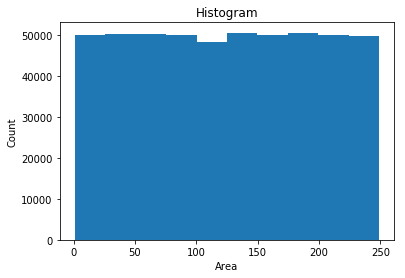

In [66]:
test = sqlc.sql("select Area from house_price_table")
pddf1 = test.toPandas()

plt.hist(pddf1.Area)
plt.xlabel('Area')
plt.ylabel('Count')
plt.title('Histogram')
plt.show()

#### Histogram for Floors

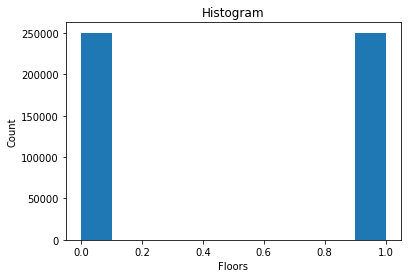

In [67]:
test = sqlc.sql("select Floors from house_price_table")
pddf1 = test.toPandas()

plt.hist(pddf1.Floors)
plt.xlabel('Floors')
plt.ylabel('Count')
plt.title('Histogram')
plt.show()

#### Histogram for Price

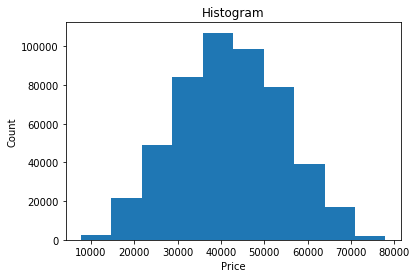

In [109]:
test = sqlc.sql("select Prices from house_price_table")
pddf1 = test.toPandas()

plt.hist(pddf1.Prices)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Histogram')
plt.show()

#### Correlation matrix

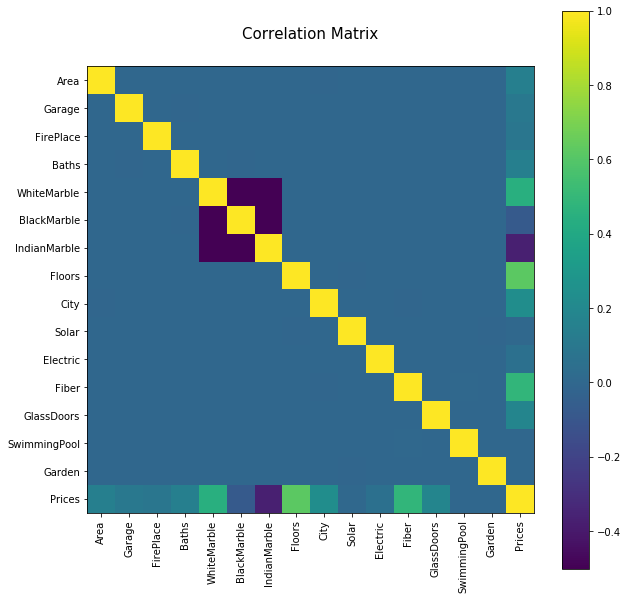

<Figure size 432x288 with 0 Axes>

In [68]:
# calculate correlation between variables
corr = df2.toPandas().corr()

# plot heatmap for correlation
plt.figure(num=None, figsize=(10, 10))
corrMat = plt.matshow(corr, fignum = 1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.gca().xaxis.tick_bottom()
plt.colorbar(corrMat)
plt.title('Correlation Matrix', fontsize=15)
plt.show()
plt.savefig("corrMatrix.jpg")
# cite: https://www.kaggle.com/kerneler/starter-housepricing-f33c5910-8

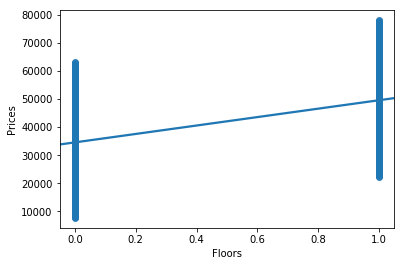

In [69]:
# the following uses seaborn to visualize the linear relationship between Floors and Prices. 
import seaborn as sns
sns.regplot(x="Floors", y="Prices", data=df2.toPandas())